In [1]:
import numpy as np
import healpy as hp
import pyccl as ccl
import pylab as plt
import math
from glob import glob
%matplotlib inline

In [2]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.8, n_s=0.96, 
                      Neff=0,m_nu=0,Omega_k=0,transfer_function='eisenstein_hu',
                      matter_power_spectrum='halofit')
#cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, transfer_function='boltzmann_class')

mass_def = ccl.halos.MassDef('vir', 'matter')
hmf = ccl.halos.MassFuncSheth99(cosmo=cosmo, mass_def=mass_def,mass_def_strict=False,use_delta_c_fit=True)
hbf = ccl.halos.HaloBiasSheth99(cosmo=cosmo, mass_def=mass_def,mass_def_strict=False)
cM = ccl.halos.ConcentrationDuffy08(mdef=mass_def)
prf = ccl.halos.HaloProfileNFW(c_M_relation=cM)
hmc = ccl.halos.HMCalculator(cosmo=cosmo, massfunc=hmf, hbias=hbf,mass_def=mass_def)

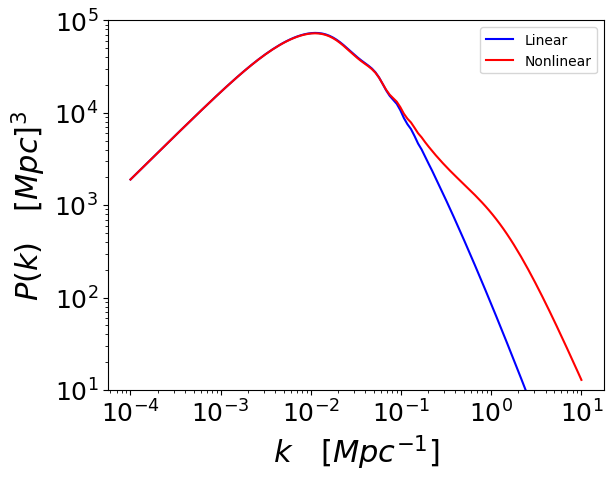

In [3]:

# Wavenumber
kmin=1e-4
kmax=1e1
nk=128
k = np.logspace(np.log10(kmin), np.log10(kmax), nk) 

# Scale factor
a = 1. 

# Calculate different P(k)
pk_li = ccl.linear_matter_power(cosmo, k, a)
pk_nl = ccl.nonlin_matter_power(cosmo, k, a)
#pk_hm = ccl.halos.halomod_power_spectrum(cosmo, hmc, k, a, prf, normprof1=True)

plt.plot(k, pk_li, 'b-',  label='Linear')
#plt.plot(k, pk_hm, 'g-',  label='Halo model')
plt.plot(k, pk_nl, 'r-',  label='Nonlinear')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r'$k\quad[Mpc^{-1}]$',fontsize=22)
plt.ylabel(r'$P(k)\quad[Mpc]^3$',fontsize=22)
plt.ylim([1e1,1e5])
plt.legend()
plt.show()

In [4]:
import treecorr

In [5]:

def healpix_to_radec(nside):
    # Total number of pixels for the given nside
    npix = hp.nside2npix(nside)
    
    # Get the theta and phi coordinates for all pixels
    theta, phi = hp.pix2ang(nside, np.arange(npix))
    
    # Convert theta and phi to RA and Dec
    dec = np.degrees(0.5 * np.pi - theta)  # Dec is the colatitude converted to latitude
    ra = np.degrees(phi)  # RA is the azimuthal angle
    
    return ra, dec

nside = 8192  # Example nside value
ra, dec = healpix_to_radec(nside)

In [6]:
kappa = hp.read_map('/lustre/work/akira.tokiwa/Projects/LensingSSC/data/bigbox/rfof_proc131072_nc6144_size3750_nsteps60lin_ldr0_rcvfalse_fstnone_pnf2_lnf2_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_8192_rfofkdt_8/kappa/kappa_zs2.0_100.fits')

In [7]:
# version of treecorr
print(treecorr.__version__)

5.0.1


In [8]:
cat = treecorr.Catalog(ra=ra[:10**3], dec=dec[:10**3], k=kappa[:10**3],ra_units='deg', dec_units='deg')

In [12]:
kk = treecorr.KKCorrelation(min_sep=1, max_sep=200, nbins=15, sep_units='arcmin')

In [13]:
import time
print('bin_size = %.6f'%kk.bin_size)
t1 = time.time()
kk.process(cat)  # Takes approx 1 minute / million objects
t2 = time.time()
print('Time for calculating kk correlation = ',t2-t1)

bin_size = 0.353221
Time for calculating kk correlation =  0.02618408203125


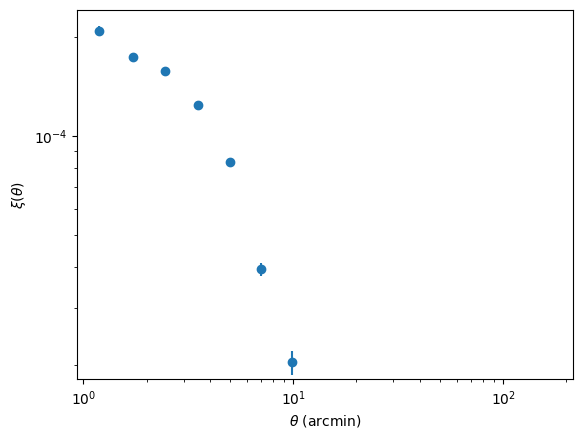

In [16]:
r = np.exp(kk.meanlogr)
xi = kk.xi
sig = np.sqrt(kk.varxi)

plt.errorbar(r, xi, yerr=sig, fmt='o')
plt.xscale('log')
plt.yscale('log', nonpositive='clip')
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$\xi(\theta)$')
plt.show()